# Compute PI

## Set up useful functions

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Callable
from time import time_ns
from tqdm import tqdm
import numpy as np
import random

In [43]:
SEED = 42
STEPS = [100, 10000, 100000, 10000000]
NB_REPEAT = 10

In [44]:
def benchmark(func: Callable[[int], int], steps: List[int], nb_repeat: int = 1) -> np.ndarray:
    times = np.zeros((len(steps), nb_repeat))

    for i, step in enumerate(tqdm(steps)):
        for j in range(nb_repeat):
            t0 = time_ns()
            func(step, SEED)
            times[i, j] = time_ns() - t0

    return times


In [45]:
def compute_metrics(times: np.ndarray) -> np.ndarray:
    # Function to compute the mean, standard deviation and median of the times
    metrics = np.zeros((times.shape[0], 3))

    for i in range(times.shape[0]):
        metrics[i, 0] = np.mean(times[i])
        metrics[i, 1] = np.std(times[i])
        metrics[i, 2] = np.median(times[i])

    return metrics


In [46]:
# Datastructure to store the functions, their names, the steps and the results
compute_pi_df = pd.DataFrame(columns=['name', 'function', 'steps', 'times', 'metrics'])

C:\Users\cleme\AppData\Local\Temp\ipykernel_18836\731872245.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


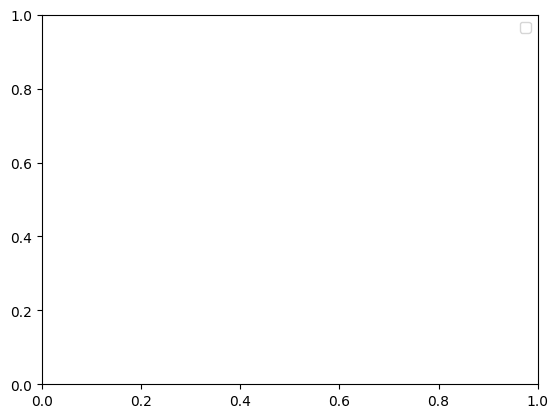

In [47]:
# Benchmark and plot code
for i, row in compute_pi_df.iterrows():
    print(f"Benchmarking {row['name']} method")
    row['times'] = benchmark(row['function'], row['steps'], nb_repeat=1)
    row['metrics'] = compute_metrics(row['times'])

for i, row in compute_pi_df.iterrows():
    plt.plot(row['steps'], row['times'], label=row['name'])
plt.legend()

## Naive python implementation

In [48]:
def compute_pi_integral(num_trial, _ = None):
    step = 1.0 / num_trial
    sum = 0.0
    for j in range(num_trial):
        x = (j - 0.5) * step
        sum += 4.0 / (1.0 + x * x)
    return step * sum

def compute_pi_metropolis(num_trial, seed):
    counter = 0.0
    random.seed(seed)

    for _ in range(num_trial):
        x_val = random.random()
        y_val = random.random()

        radius = x_val ** 2 + y_val ** 2
        if radius < 1.0:
            counter += 1.0

    return 4.0 * counter / num_trial


In [49]:
compute_pi_df.loc[0] = {
    'name': 'Integral',
    'function': compute_pi_integral,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

compute_pi_df.loc[1] = {
    'name': 'Metropolis',
    'function': compute_pi_metropolis,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

## Generator function implementation

In [50]:
def generator_integral(num_trial, step):
    for j in range(num_trial):
        x = (j - 0.5) * step
        yield 4.0 / (1.0 + x * x)

def compute_pi_integral_gen(num_trial, _ = None):
    step = 1.0 / num_trial
    return sum(generator_integral(num_trial, step)) * step        


def generator_metropolis(num_trial, seed):
    random.seed(seed)

    for _ in range(num_trial):
        x_val = random.random()
        y_val = random.random()

        radius = x_val ** 2 + y_val ** 2
        if radius < 1.0:
            yield 1
        else:
            yield 0

def compute_pi_metropolis_gen(num_trial, seed):
    return 4.0 * sum(generator_metropolis(num_trial, seed)) / num_trial


In [51]:
compute_pi_df.loc[2] = {
    'name': 'Integral Generator',
    'function': compute_pi_integral_gen,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

compute_pi_df.loc[3] = {
    'name': 'Metropolis Generator',
    'function': compute_pi_metropolis_gen,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

## Lambda function implementation

In [52]:
compute_pi_integral_lambda = lambda num_trial, _: sum([4.0 / (1.0 + ((j - 0.5) / num_trial) ** 2) for j in range(num_trial)]) / num_trial
compute_pi_metropolis_lambda = lambda num_trial, _: 4.0 * sum([1 for _ in range(num_trial) if (random.random() ** 2 + random.random() ** 2) < 1.0]) / num_trial
compute_pi_metropolis_lambda_filter = lambda num_trial, _: 4.0 * len(list(filter(lambda _: (random.random() ** 2 + random.random() ** 2) < 1, range(num_trial)))) / num_trial

In [53]:
compute_pi_df.loc[4] = {
    'name': 'Integral Lambda',
    'function': compute_pi_integral_lambda,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

compute_pi_df.loc[5] = {
    'name': 'Metropolis Lambda',
    'function': compute_pi_metropolis_lambda,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

compute_pi_df.loc[6] = {
    'name': 'Metropolis Lambda Filter',
    'function': compute_pi_metropolis_lambda_filter,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

## Function implementation with Numpy

In [54]:
def compute_pi_integral_numpy(num_trial, _ = None):
    step = 1.0 / num_trial
    tot = np.fromfunction(lambda j: 4.0 / (1.0 + ((j - 0.5) * step) ** 2), (num_trial,))
    return step * tot.sum()


def compute_pi_metropolis_numpy(num_trial, seed):
    random.seed(seed)
    vect = np.vectorize(lambda _: random.random() ** 2 + random.random() ** 2)
    tot = vect(np.zeros(num_trial))
    return 4.0 * np.sum(tot < 1.0) / num_trial

def compute_pi_metropolis_numpy_v2(num_trial, seed):
    np.random.seed(seed)
    
    x_vals = np.random.random(num_trial)
    y_vals = np.random.random(num_trial)
    
    radii = x_vals**2 + y_vals**2    
    return 4.0 * np.sum(radii < 1.0)/ num_trial

# TODO: Faire avec np.random.rand(num_trial) ** 2 + np.random.rand(num_trial) ** 2
# TODO: Faire sans from function mais avec np.arange(num_trial) puis les calculs sur tout le tableau
# TODO: Utiliser le random de numpy

In [55]:
compute_pi_df.loc[7] = {
    'name': 'Integral Numpy',
    'function': compute_pi_integral_numpy,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

compute_pi_df.loc[8] = {
    'name': 'Metropolis Numpy Vectorize',
    'function': compute_pi_metropolis_numpy,
    'steps': STEPS,
    'times': None,
    'metrics': None

}
compute_pi_df.loc[9] = {
    'name': 'Metropolis Numpy',
    'function': compute_pi_metropolis_numpy_v2,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

## Numba implementation

In [56]:
import numba

@numba.jit(nopython=True)
def pi_integral_numba(num_trial, _ = None):
    step = 1.0/num_trial
    sum = 0
    for j in range(num_trial):
        x = (j - 0.5) * step
        sum = sum + 4.0/(1.0 + x * x)
    return sum * step

@numba.jit(nopython=True)
def pi_metropolis_numba(num_trial, seed):
    counter = 0.0
    random.seed(seed)
    for _ in range(num_trial):
        x_val = random.random()
        y_val = random.random()
        radius = x_val ** 2 + y_val ** 2
        if radius < 1:
            counter += 1
    return 4 * counter/num_trial

In [57]:
compute_pi_df.loc[10] = {
    'name': 'Integral Numba',
    'function': pi_integral_numba,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

compute_pi_df.loc[11] = {
    'name': 'Metropolis Numba',
    'function': pi_metropolis_numba,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

## Pandas implementation

In [74]:
import pandas as pd

def compute_pi_integral_pandas(num_trial, _ = None):
    step = 1.0 / num_trial
    tot = pd.Series(np.arange(num_trial))
    tot = 4.0 / (1.0 + ((tot - 0.5) * step) ** 2)
    return step * tot.sum()

def compute_pi_metropolis_pandas(num_trial, seed):
    random.seed(seed)
    X_val = pd.Series(np.random.random(num_trial))
    Y_val = pd.Series(np.random.random(num_trial))
    rad = X_val ** 2 + Y_val ** 2
    return 4.0 * (rad < 1.0).sum() / num_trial

# TODO: Utiliser vectorize

In [75]:
compute_pi_df.loc[12] = {
    'name': 'Integral Pandas',
    'function': compute_pi_integral_pandas,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

compute_pi_df.loc[13] = {
    'name': 'Metropolis Pandas',
    'function': compute_pi_metropolis_pandas,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

## Dask implementation

In [70]:
import dask.array as da

def compute_pi_integral_dask(num_trial, _ = None):
    step = 1.0 / num_trial
    tot = da.arange(num_trial, chunks='auto')    
    tot = 4.0 / (1.0 + ((tot - 0.5) * step) ** 2)
    result = step * tot.sum()
    return result.compute()

def compute_pi_metropolis_dask(num_trial, seed):
    da.random.seed(seed)
    x_vals = da.random.random(num_trial, chunks='auto')
    y_vals = da.random.random(num_trial, chunks='auto')
    radius = x_vals ** 2 + y_vals ** 2
    result = 4.0 * (radius < 1.0).sum() / num_trial
    return result.compute()

# TODO: Utiliser vectorize

In [61]:
compute_pi_df.loc[14] = {
    'name': 'Integral Dask',
    'function': compute_pi_integral_dask,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

compute_pi_df.loc[15] = {
    'name': 'Metropolis Dask',
    'function': compute_pi_metropolis_dask,
    'steps': STEPS,
    'times': None,
    'metrics': None
}

In [76]:
# Benchmark 
for i, row in compute_pi_df.iterrows():
    print(f"Benchmarking {row['name']} method")
    row['times'] = benchmark(row['function'], row['steps'], nb_repeat=NB_REPEAT)
    row['metrics'] = compute_metrics(row['times'])


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]
C:\Users\cleme\AppData\Local\Temp\ipykernel_18836\1475949664.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  compute_pi_df.loc[13]['times'] = benchmark(row['function'], row['steps'], nb_repea

In [63]:
compute_pi_df.metrics[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.39918000e+06, 4.88377282e+05, 1.00385000e+06],
       [1.25360300e+07, 6.01027685e+05, 1.24960000e+07],
       [1.31845240e+09, 3.89374136e+07, 1.31488800e+09]])

TypeError: 'NoneType' object is not iterable

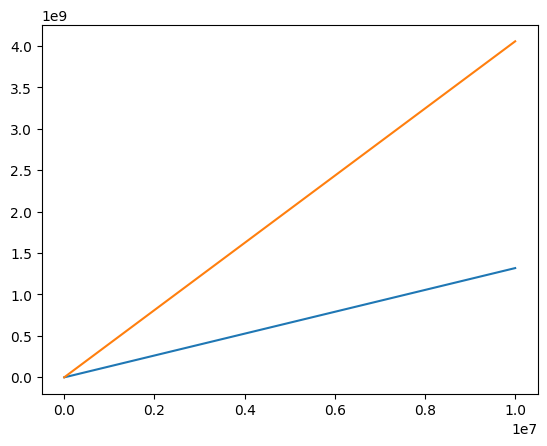

In [77]:
# Plot results
for i, row in compute_pi_df.loc[0:1].iterrows():
    mean = np.zeros((len(STEPS)))
    for j, metrics in enumerate(row['metrics']):
        mean[j] = metrics[0]
    plt.plot(row['steps'], mean, label=row['name'])
for i, row in compute_pi_df.loc[12:13].iterrows():
    mean = np.zeros((len(STEPS)))
    for j, metrics in enumerate(row['metrics']):
        mean[j] = metrics[0]
    plt.plot(row['steps'], mean, label=row['name'])
plt.xlabel("Nombre d'itérations")
plt.ylabel(f"Temps d'exécution moyen ({NB_REPEAT} exécutions)")
plt.title('Résultats de performance pour Pandas')
plt.legend()

In [1]:
# Plot results
for i, row in compute_pi_df.iterrows():
    mean = np.zeros((len(STEPS)))
    for j, metrics in enumerate(row['metrics']):
        mean[j] = metrics[0]
    plt.plot(row['steps'], mean, label=row['name'])
plt.xlabel("Nombre d'itérations")
plt.ylabel(f"Temps d'exécution moyen ({NB_REPEAT} exécutions)")
plt.title('Résultats de performance pour chaque implémentation différente')
plt.legend()

NameError: name 'compute_pi_df' is not defined

## Cython implementation

In [72]:
import cython
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [73]:
%%cython -a
import random
import numpy as np
from tqdm import tqdm
from time import time_ns
import matplotlib.pyplot as plt

def compute_pi_integral_cy(num_trial):
    cdef double step = 1.0 / num_trial
    cdef double tot = 0.0
    cdef double x = 0.0
    for j in range(int(num_trial)):
        x = (j - 0.5) * step
        tot = tot + 4.0 / (1.0 + x * x)
    return step * tot

def compute_pi_metropolis_cy(num_trial, seed):
    cdef double counter = 0.0
    random.seed(seed)

    for _ in range(int(num_trial)):
        x_val = random.random()
        y_val = random.random()

        radius = x_val ** 2 + y_val ** 2
        if radius < 1.0:
            counter += 1.0

    return 4.0 * counter / num_trial


steps = [100.0, 10000.0, 100000.0, 10000000.0]
times_integral_cython = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    compute_pi_integral_cy(step)
    times_integral_cython[i] = time_ns() - t0

print(times_integral_cython)
np.save('times_integral_cython.npy', times_integral_cython)


steps = [100.0, 10000.0, 100000.0, 10000000.0]
times_metropolis_cython = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    compute_pi_metropolis_cy(step, 10)
    times_metropolis_cython[i] = time_ns() - t0

print(times_metropolis_cython)
np.save('times_metropolis_cython.npy', times_metropolis_cython)

Content of stdout:
_cython_magic_018aeca59cd7e85cf44d5b6c5d2029d9327b3fde.c
C:\Users\cleme\.ipython\cython\_cython_magic_018aeca59cd7e85cf44d5b6c5d2029d9327b3fde.c(7160): warning C4244: '='ÿ: conversion de 'Py_ssize_t' en 'long', perte possible de donnes
   Cration de la bibliothque C:\Users\cleme\.ipython\cython\Users\cleme\.ipython\cython\_cython_magic_018aeca59cd7e85cf44d5b6c5d2029d9327b3fde.cp312-win_amd64.lib et de l'objet C:\Users\cleme\.ipython\cython\Users\cleme\.ipython\cython\_cython_magic_018aeca59cd7e85cf44d5b6c5d2029d9327b3fde.cp312-win_amd64.exp
Gnration de code en cours
Fin de la gnration du code

100%|██████████| 4/4 [00:00<00:00,  7.37it/s]


[0.000000e+00 2.011100e+06 5.005500e+06 5.335015e+08]


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

[0.0000000e+00 3.9897000e+06 3.6999600e+07 3.8944642e+09]


In [74]:
times_integral = np.load('times_integral.npy')
times_integral_gen = np.load('times_integral_gen.npy')
times_integral_lambda = np.load('times_integral_lambda.npy')
times_integral_numpy = np.load('times_integral_numpy.npy')

times_metropolis = np.load('times_metropolis.npy')
times_metropolis_gen = np.load('times_metropolis_gen.npy')
times_metropolis_lambda = np.load('times_metropolis_lambda.npy')
times_metropolis_numpy = np.load('times_metropolis_numpy.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'times_integral.npy'

In [46]:
plt.plot(steps, times_integral, label='Integral')
plt.plot(steps, times_integral_gen, label='Integral Gen')
plt.plot(steps, times_integral_lambda, label='Integral Lambda')
plt.plot(steps, times_integral_numpy, label='Integral Numpy')
plt.plot(steps, times_integral_cython, label='Integral Cython')

plt.plot(steps, times_metropolis, label='Metropolis')
plt.plot(steps, times_metropolis_gen, label='Metropolis Gen')
plt.plot(steps, times_metropolis_lambda, label='Metropolis Lambda')
plt.plot(steps, times_metropolis_numpy, label='Metropolis Numpy')
plt.plot(steps, times_metropolis_cython, label='Metropolis Cython')

plt.legend()

NameError: name 'times_integral' is not defined